# Jane Street - Tuner

In [1]:
import joblib
import json
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from xgboost import XGBClassifier

In [2]:
# load NN model
model_folder = os.path.join(os.pardir, "input", "jane-street-nn")

with open(os.path.join(model_folder, "model.json"), "r") as f:
    nn = keras.models.model_from_json(f.read())

nn.load_weights(os.path.join(model_folder, "model.h5"))
nn.call = tf.function(nn.call, experimental_relax_shapes=True)

nn_pp = joblib.load(os.path.join(model_folder, "preprocessor.pkl"))


# load EDA XGB model
model_folder = os.path.join(os.pardir, "input", "jane-street-eda-xgb")

edaxgb = XGBClassifier()
edaxgb.load_model(os.path.join(model_folder, "model.xgb"))

edaxgb_pp = joblib.load(os.path.join(model_folder, "preprocessor.pkl"))


# load PLS XGB model
model_folder = os.path.join(os.pardir, "input", "jane-street-pls-xgb")

plsxgb = XGBClassifier()
plsxgb.load_model(os.path.join(model_folder, "model.xgb"))

plsxgb_pp = joblib.load(os.path.join(model_folder, "preprocessor.pkl"))


# ensemble weights and threshold
weights = {"nn": 1 / 3, "eda-xgb": 1 / 3, "pls-xgb": 1 / 3}
threshold = 0.5

In [3]:
# read data as 32 bit floats
file = os.path.join(os.pardir, "input", "jane-street-market-prediction", "train.csv")
dtype = {c: np.float32 for c in pd.read_csv(file, nrows=1).columns}
full_df = pd.read_csv(file, engine="c", dtype=dtype)
features = [c for c in full_df.columns if "feature" in c]

# NN predictions
valid_df = full_df[full_df["date"].between(425, 500)]
X = valid_df[features].to_numpy()
X = nn_pp.transform(X)
nnprobs = nn.predict(X).squeeze()

# EDA XGB predictions
valid_df = full_df[full_df["date"].between(425, 500)]
X = valid_df[features].to_numpy()
X = edaxgb_pp.transform(X)
edaxgbprobs = edaxgb.predict_proba(X)
edaxgbprobs = edaxgbprobs[:, 1]

# PLS XGB predictions
valid_df = full_df[full_df["date"].between(425, 500)]
X = valid_df[features].to_numpy()
X = plsxgb_pp.transform(X)
plsxgbprobs = plsxgb.predict_proba(X)
plsxgbprobs = plsxgbprobs[:, 1]

In [ ]:
# ensemble probs
weights = {"nn": 1/3, "eda-xgb": 1/3, "pls-xgb": 1/3}
probs = weights["nn"] * nnprobs + weights["eda-xgb"] * edaxgbprobs \
      + weights["pls-xgb"] * plsxgbprobs

Optimal threshold at p = 0.50174


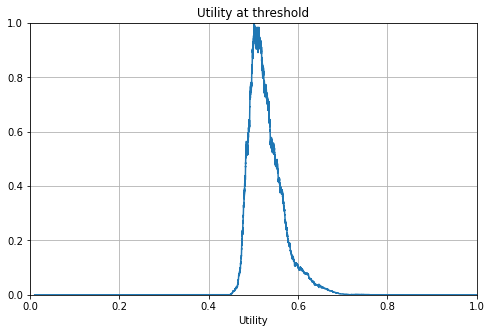

In [4]:
# relevant data to compute utility
valid_df = full_df[full_df["date"].between(425, 500)]
resp = valid_df["resp"].to_numpy()
weight = valid_df["weight"].to_numpy()
date = valid_df["date"].astype(np.int).to_numpy()

# utility function as defined above
def utility(threshold):
    action = np.heaviside(probs - threshold, 0.0)
    p = np.bincount(date, weight * resp * action)
    
    if np.sum(p ** 2) == 0.0:
        return 0.0
    
    t = np.sum(p) / np.sqrt(np.sum(p ** 2)) * np.sqrt(250 / p.size)
    u = min(max(t, 0), 6) * np.sum(p)
    
    return u

# compute utilities at different thresholds and select the best one
thresholds = np.arange(0.01, 1.0, 1e-5)
utilities = np.array([utility(thresh) for thresh in thresholds])
utilities = (utilities - utilities.min()) / (utilities.max() - utilities.min())
best = thresholds[np.argmax(utilities)]
best = np.round(best, 5)

# save the best threshold
with open(os.path.join(os.curdir, "threshold.json"), "w") as file:
    json.dump({"threshold": str(best)}, file)
    
# plot utility curve and print best threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, utilities, "tab:blue")
plt.xlabel("Threshold")
plt.xlabel("Utility")
plt.title("Utility at threshold")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

print(f"Optimal threshold at p = {best}")